* Data Source : http://www.manythings.org/anki/ita-eng.zip

In [ ]:
# unzip data
!unzip "/content/ita-eng.zip"

Archive:  /content/ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [ ]:
!curl --header "Host: downloads.cs.stanford.edu" --header "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header "Accept-Language: en-US,en;q=0.9" --header "Referer: https://nlp.stanford.edu/" --header "Cookie: _ga=GA1.2.545929601.1671976005; _gid=GA1.2.4584345.1673281263; _gat=1" --header "Connection: keep-alive" "https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip" -L -o "glove.6B.zip"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  822M  100  822M    0     0  5288k      0  0:02:39  0:02:39 --:--:-- 5889k


In [ ]:
!unzip "/content/glove.6B.zip"

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


#### Import Packages

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from tensorflow.keras import callbacks
import warnings
import matplotlib.ticker as ticker
warnings.filterwarnings("ignore")

##### Data Preprocess

In [ ]:
# load data file
# extract english and italian text from text file
with open('ita.txt', 'r', encoding="utf8") as f:

    # store eng and ita text
    eng, ita = [ ], [ ]
    for line in f.readlines():
        # extract data
        eng.append(line.split("\t")[0])
        ita.append(line.split("\t")[1])

# create data frame
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)

(358373, 2)


In [ ]:
data.sample(10)                         # samples

,english,italian
136813,I almost never watch TV.,Non guardo quasi mai la televisione.
40202,Please enter now.,"Per favore, entrate ora."
304771,Why are you looking at me like that?,Perché mi sta guardando così?
287745,We enjoyed ourselves at the party.,Ci siamo divertite alla festa.
305238,You seem to be waiting for somebody.,Sembra che voi stiate aspettando qualcuno.
237523,That's how we do it in Boston.,È come la facciamo a Boston.
299960,I don't think that Tom is in Boston.,Non penso che Tom sia a Boston.
206569,My favorite subject is math.,La mia materia preferita è matematica.
21592,She helped him.,Lo aiutò.
10698,Tom's not in.,Tom non è dentro.


In [ ]:
def decontractions(phrase):


    '''
    Input :
        name    : phrase
        type    : str
        content : text data of english sentence

    Output :
        name    : phrase
        type    : str
        content : preprocess text

    Process :
        This function take text data as input and
        decontractions words in text and return clean text.

    Ref : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#470

    '''



    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrasedef decontractions(phrase):


    '''
    Input :
        name    : phrase
        type    : str
        content : text data of english sentence

    Output :
        name    : phrase
        type    : str
        content : preprocess text

    Process :
        This function take text data as input and
        decontractions words in text and return clean text.

    Ref : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#470

    '''

    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [ ]:
for i in range(0,101,10):
 print(i ,np.percentile(ita_len, i))

for i in range(90,101):
 print(i ,np.percentile(ita_len, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0


In [ ]:
for i in np.arange(99.0, 100.1, 0.1):
    print(round(i, 2),np.percentile(ita_len, i))

99.0 12.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 22.0
100.0 92.0


* We see that in italian sentences, 99.9% of the sentence less than equal to 22
len, only 0.1% of the sentences length is greate than 20 len. so we
will set length of the sentence is 22.

In [ ]:
lenn = 22

# calculate italian text len
data['italian_len'] = data['italian'].str.split().str.len()
# set up condition based on text len
data = data[data['italian_len'] < lenn]

# calculate italian text len
data['english_len'] = data['english'].str.split().str.len()
# set up condition based on text len
data = data[data['english_len'] < lenn]

# add <start> and <end> token in italian text, 
data['italian'] = '<start> ' + data['italian'].astype(str) + " <end>"

# add <start> and <end> token in english text
data['english_inp'] = '<start> ' + data['english'].astype(str) + " <end>"

# <end> token in english text
data['english_out'] = data['english'].astype(str) + ' <end>'

# drop text len columns
data = data.drop(['english','italian_len','english_len'], axis=1)

data.head()

,italian,english_inp,english_out
0,<start> ciao <end>,<start> hi <end>,hi <end>
1,<start> ciao <end>,<start> hi <end>,hi <end>
2,<start> corri <end>,<start> run <end>,run <end>
3,<start> corra <end>,<start> run <end>,run <end>
4,<start> correte <end>,<start> run <end>,run <end>


In [ ]:
data.sample(10)

,italian,english_inp,english_out
230420,<start> hai dei piani per stasera <end>,<start> do you have plans for tonight <end>,do you have plans for tonight <end>
216150,<start> lei è mai stata in canada <end>,<start> have you ever been to canada <end>,have you ever been to canada <end>
64119,<start> sta studiando ora <end>,<start> is he studying now <end>,is he studying now <end>
26920,<start> io devo lottare <end>,<start> i have to fight <end>,i have to fight <end>
144583,<start> tom ha molti vestiti <end>,<start> tom has lots of clothes <end>,tom has lots of clothes <end>
139007,<start> io penso che tom sia preparato <end>,<start> i think tom is prepared <end>,i think tom is prepared <end>
187910,<start> mi ricorderò sempre di voi <end>,<start> i will always remember you <end>,i will always remember you <end>
267341,<start> cosa ne pensate dellarte moderna <end>,<start> what do you think of modern art <end>,what do you think of modern art <end>
345051,<start> io dovrei chiamare la polizia e farla ...,<start> i should call the police and have you ...,i should call the police and have you arrested...
111142,<start> non è sufficientemente grande <end>,<start> that is not big enough <end>,that is not big enough <end>


In [ ]:
# data.to_csv("preprocess_seq_to_seq_model_data.csv", index=False)

##### Data Prepration

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state= 42, shuffle= True)
print(train.shape)
print(test.shape)

(286355, 3)
(71589, 3)


In [ ]:
# tokeniser in the italian data 
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)

# tokeniser in the english data
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

print('Unique words in the english and italian language - ')

# len of english token dict
vocab_size_eng = len(tknizer_eng.word_index.keys())
print('vocab english - ', vocab_size_eng)

# len of english token dict
vocab_size_ita = len(tknizer_ita.word_index.keys())
print("vocab italian - ",vocab_size_ita)


Unique words in the english and italian language - 
vocab english -  13192
vocab italian -  26846


In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']              # print <start> <end>

(1, 2)

In [ ]:
index_word = {index: word for word, index in tknizer_eng.word_index.items()}    # convert token : seq into seq : token
len(index_word)

13192

In [ ]:
index_word = {index: word for word, index in tknizer_eng.word_index.items()}
len(index_word)

13192

In [ ]:
# Ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# Getting the pre-trained embeddings.

embeddings_index = dict()
f = open('/content/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training english sentences.
embedding_matrix = np.zeros((vocab_size_eng + 1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

##### Data-loader 

In [ ]:
# Creating the batch dataset for train and validation.
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):

        ############# italian, english input and english output ###########

        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len                                                  # max len value

    def __getitem__(self, i):

        ################### convert texts into sequences ###################

        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) 
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        ############## apply padding seqeuence #############

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):

        ############# entire dataset and batch size #############
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
################ prepare dataset ###############

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, lenn)
test_dataset  = Dataset(test, tknizer_ita, tknizer_eng, lenn)

In [ ]:
################ generate data based on data loader ###########

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader  = Dataloder(test_dataset, batch_size=1024)

In [ ]:
print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)      # check shape

(1024, 22) (1024, 22) (1024, 22)


##### Encoder Decoder with Attention Mechanism

In [ ]:
# Encoder Architecture
tf.keras.backend.clear_session()
class Encoder(Model):
    def __init__(self, vocab_size, embed_size, units, input_len):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size + 1
        self.embed_dim = embed_size
        self.input_length = input_len
        self.lstm_units = units
        self.lstm_output = 0
        self.lstm_state_h = 0
        self.lstm_state_c = 0
        self.embeddings = Embedding(input_dim = self.vocab_size, output_dim = self.embed_dim,
                                    input_length = self.input_length, name = 'Encoder_Emb_Layer')
        self.lstm = LSTM(units = self.lstm_units, return_sequences = True,
                        return_state = True, name = 'Encoder_LSTM_Layer')
    
    def call(self, input_sentence, hidden, training = True):

        input_emb = self.embeddings(input_sentence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.lstm(input_emb, initial_state = hidden)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c
    
    def get_states(self):
        return self.lstm_state_h, self.lstm_state_c
    
    def initialize_states(self,batch_size):
        self.lstm_state_h = tf.zeros((batch_size, self.lstm_units))
        self.lstm_state_c = tf.zeros((batch_size, self.lstm_units))
        return [self.lstm_state_h, self.lstm_state_c] 

In [ ]:
# BahdanauAttention
# Ref: https://arxiv.org/pdf/1508.04025.pdf
'''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
class Attention(tf.keras.layers.Layer):
    def __init__(self, att_func, att_units):
        super(Attention, self).__init__()
        self.units = att_units
        self.func = att_func
    
    def build(self, input_shape):
        if(self.func == 'general'):
            self.Wa = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform',
                               trainable=True)
        if(self.func == 'concat'):
            self.W1 = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform',
                               trainable=True)
            self.W2 = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform',
                               trainable=True)
            self.va = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform',
                               trainable=True)

    def call(self, decoder_hidden_state, encoder_output):
        query = tf.expand_dims(decoder_hidden_state, axis = 1)

        # query: (batch_size, 1, rnn_units)
        # encoder_output a.k.a values: (batch_size, max_len, rnn_units)

        # Three ways of calculating attention weights
        if self.func == 'dot':
            scores = tf.matmul(encoder_output, query, transpose_b = True)
        
        if self.func == 'general':
            temp = tf.matmul(encoder_output, self.Wa, transpose_b = True)
            scores = tf.matmul(temp, query, transpose_b = True)
            
        if self.func == 'concat':
            temp = tf.matmul(query, self.W1, transpose_b = True) + tf.matmul(encoder_output, self.W2, transpose_b = True)
            temp = tf.nn.tanh(temp)
            scores = tf.matmul(temp, self.va)
        
        attention_weights = tf.nn.softmax(scores, axis = 1)
        
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
            
            

In [ ]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units, embedding_matrix):
        super(One_Step_Decoder, self).__init__()

        # Initialize decoder embedding layer, LSTM and any other objects needed
        self.embedding = Embedding(input_dim = tar_vocab_size + 1, output_dim = embedding_dim, mask_zero=True,
                                   input_length = input_length, weights=[embedding_matrix], trainable=False)
        self.attention = Attention(score_fun, att_units)
        self.lstm = LSTM(units = dec_units, return_sequences = True,
                        return_state = True)
        self.dense = Dense(units = tar_vocab_size, activation = 'softmax')
        

    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        # A
        embedded = self.embedding(input_to_decoder)
        # B
        context_vector, attention_weights = self.attention(state_h, encoder_output)
        temp = tf.expand_dims(context_vector, axis = 1)

        # C
        temp = tf.concat([embedded, temp], axis=-1)

        # D
        decoded_op, decoded_h, decoded_c = self.lstm(temp)
        decoded_op = tf.squeeze(decoded_op, axis = 1)

        # E
        output = self.dense(decoded_op)
        
        # F
        return output, decoded_h, decoded_c, attention_weights, context_vector
        
        

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units, emb_matrix):

      #Intialize necessary variables and create an object from the class onestepdecoder
        super(Decoder, self).__init__()
        self.onestepdecoder = One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units, emb_matrix)
        self.max_len = input_length
    def call(self, input_to_decoder, encoder_output, decoder_h, decoder_c):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array

        Output = tf.TensorArray(tf.float32, size = self.max_len)
        
        for step in range(self.max_len):
            output, decoder_h, decoder_c, att_weights, _ = self.onestepdecoder(input_to_decoder[:, step:step+1], encoder_output, 
                                                              decoder_h, decoder_c)
            
            Output = Output.write(step, output)
            
        Output = tf.transpose(Output.stack(), [1, 0, 2])
        
        return Output, att_weights              

In [ ]:
# Creating the overall model architecture
class Encoder_Decoder(Model):
    def __init__(self, ip_vocab_size, ip_embed_size, input_len, units, op_vocab_size, op_embed_size, output_len, score_func, batch_size, emb_matrix):
        super(Encoder_Decoder, self).__init__() 
        
        self.batch_size = batch_size
        self.encoder = Encoder(ip_vocab_size, ip_embed_size, units, input_len)
        self.decoder = Decoder(op_vocab_size, op_embed_size, output_len, units ,score_func, 
                               units, emb_matrix)
        #self.dense = Dense(units = op_vocab_size, activation = 'softmax')
    
    def call(self, data):

        initial_state = self.encoder.initialize_states(self.batch_size)
        lang1, lang2 = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(lang1, initial_state) # Encoder
        decoder_output, _  = self.decoder(lang2, encoder_output, encoder_h, encoder_c) # Decoder
        return decoder_output

In [ ]:
# Ref: https://www.tensorflow.org/tutorials/text/nmt_with_attention
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

def loss_function(y_true, y_pred):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  loss_ = loss_object(y_true, y_pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
def predict(text, md):

  print("=" * 30, "Inference", "=" * 30)

  test = tknizer_ita.texts_to_sequences([text])
  test = pad_sequences([test[0]], maxlen=20, dtype='int32', padding='post')
  test = tf.convert_to_tensor(test)

  initial_state = md.layers[0].initialize_states(1)
  enc_output, enc_state_h, enc_state_c = md.layers[0](test, initial_state)
  state_h, state_c = enc_state_h, enc_state_c

  pred = []
  cur_vec = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)

  print('-'*20,"started predition","-"*20)
  print("at time step 0 the word is 0")

  ATT = np.zeros((20, 20))

  for i in range(20):

      infe_output, state_h, state_c, att_weights, _ = md.layers[1].onestepdecoder(cur_vec, enc_output, state_h, state_c)
      # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
      # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape

      att_weights = tf.reshape(att_weights, (-1, ))

      cur_vec1 = np.argmax(infe_output)
      cur_vec = np.reshape(np.argmax(infe_output), (1, 1))

      ATT[i] = att_weights.numpy()
      print("at time step", i, "the word is ", cur_vec)

      pred.append(cur_vec1)

      if cur_vec1 == tknizer_eng.word_index['<end>']:
          
        break
  return pred, ATT

In [ ]:
def display(ita, eng_ref, pred):

  print('Italian: ', ita)
  print('Eng_ref: ', eng_ref)

  result = ''
  for i in pred:
    if i != 0:
      result += tknizer_eng.index_word[i] + ' '

  print('Predicted: ', result)
  reference = [eng_ref.split()] # the original
  translation = result.split() # translated using model
  print()
  
  print('BLEU score: {}'.format(sentence_bleu(reference, translation[:-1])))
  return result

In [ ]:
def plot(att, ita, pred):

    attention_plot = att[:len(pred.split(' ')), :len(ita.split(' '))]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.matshow(attention_plot, cmap = 'viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + ita.split(), fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + pred.split(), fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

###### General Attention Mechanism

In [ ]:
tf.keras.backend.clear_session()

model  = Encoder_Decoder(ip_vocab_size = vocab_size_ita+1, 
                         ip_embed_size = 100, 
                         input_len = 22, 
                         units = 64, 
                         op_vocab_size = vocab_size_eng, 
                         op_embed_size = 100, 
                         output_len = 22, 
                         score_func = 'dot', 
                         batch_size = 1024, 
                         emb_matrix = embedding_matrix)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer = optimizer,loss = [loss_function])

train_steps = train.shape[0]//1024
valid_steps = test.shape[0]//1024
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=test_dataloader, validation_steps=valid_steps)
model.summary()

Epoch 1/50
279/279 [==============================] - 150s 419ms/step - loss: 1.8832 - val_loss: 1.6856
Epoch 2/50
279/279 [==============================] - 109s 391ms/step - loss: 1.6915 - val_loss: 1.6794
Epoch 3/50
279/279 [==============================] - 109s 390ms/step - loss: 1.6639 - val_loss: 1.6278
Epoch 4/50
279/279 [==============================] - 109s 390ms/step - loss: 1.5937 - val_loss: 1.5429
Epoch 5/50
279/279 [==============================] - 109s 390ms/step - loss: 1.5093 - val_loss: 1.4574
Epoch 6/50
279/279 [==============================] - 109s 391ms/step - loss: 1.4081 - val_loss: 1.3390
Epoch 7/50
279/279 [==============================] - 109s 392ms/step - loss: 1.2826 - val_loss: 1.2171
Epoch 8/50
279/279 [==============================] - 109s 392ms/step - loss: 1.1633 - val_loss: 1.1105
Epoch 9/50
279/279 [==============================] - 110s 393ms/step - loss: 1.0640 - val_loss: 1.0204
Epoch 10/50
279/279 [==============================] - 110s 395m

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[51]]
at time step 1 the word is  [[55]]
at time step 2 the word is  [[9]]
at time step 3 the word is  [[365]]
at time step 4 the word is  [[2]]

Italian:  <start> saliamo sullautobus <end>
Eng_ref:  <start> let is get on the bus <end>
Predicted:  there were the bus <end> 

BLEU score: 3.506226123743032e-155



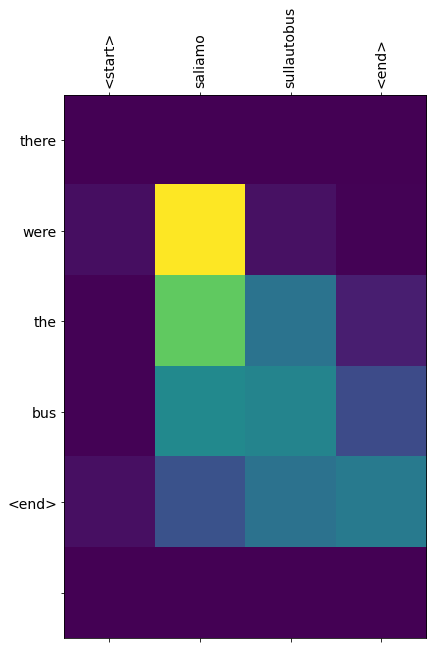

In [ ]:
num = test.sample(1).index[0]
Ita = test['italian'][num]
Eng = test['english_inp'][num]

pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[3]]
at time step 1 the word is  [[28]]
at time step 2 the word is  [[4033]]
at time step 3 the word is  [[84]]
at time step 4 the word is  [[2]]

Italian:  <start> io posso consolarla <end>
Eng_ref:  <start> i can comfort her <end>
Predicted:  i can comfort her <end> 

BLEU score: 0.6065306597126334



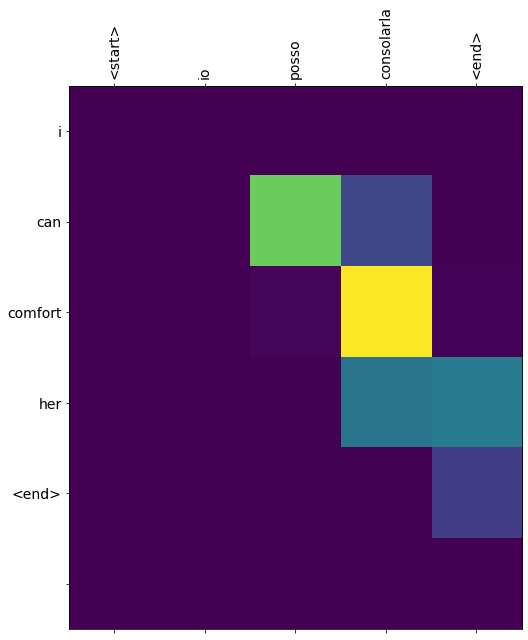

In [ ]:
num = test.sample(1).index[0]
Ita = test['italian'][num]
Eng = test['english_inp'][num]

pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[16]]
at time step 1 the word is  [[2225]]
at time step 2 the word is  [[35]]
at time step 3 the word is  [[113]]
at time step 4 the word is  [[16]]
at time step 5 the word is  [[74]]
at time step 6 the word is  [[2451]]
at time step 7 the word is  [[2]]

Italian:  <start> lui si comportò come se lo avessimo insultato <end>
Eng_ref:  <start> he acted as though we had insulted him <end>
Predicted:  he acted like if he had insulted <end> 

BLEU score: 6.419573613943772e-155



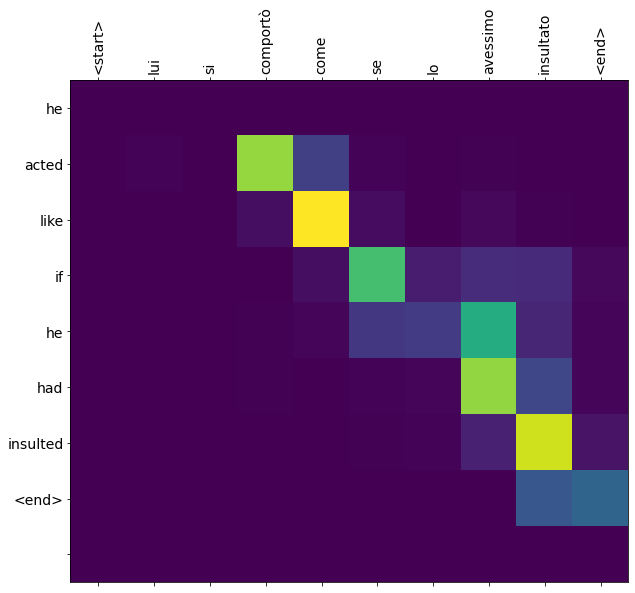

In [ ]:
num = test.sample(1).index[0]
Ita = test['italian'][num]
Eng = test['english_inp'][num]

pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[3]]
at time step 1 the word is  [[183]]
at time step 2 the word is  [[4]]
at time step 3 the word is  [[11]]
at time step 4 the word is  [[8]]
at time step 5 the word is  [[382]]
at time step 6 the word is  [[2]]

Italian:  <start> spero che non ti dispiaccia <end>
Eng_ref:  <start> i hope you do not mind <end>
Predicted:  i hope you do not mind <end> 

BLEU score: 0.7165313105737893



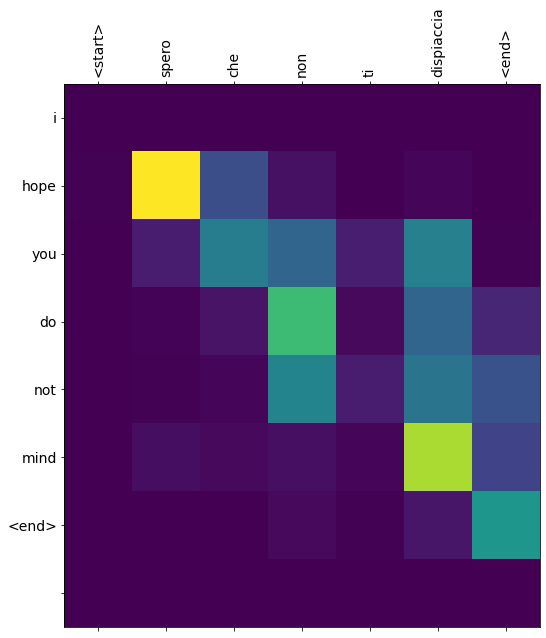

In [ ]:
num = test.sample(1).index[0]
Ita = test['italian'][num]
Eng = test['english_inp'][num]

pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[5]]
at time step 1 the word is  [[23]]
at time step 2 the word is  [[8]]
at time step 3 the word is  [[150]]
at time step 4 the word is  [[9]]
at time step 5 the word is  [[1107]]
at time step 6 the word is  [[157]]
at time step 7 the word is  [[2]]

Italian:  <start> tom non ha letto il giornale ieri <end>
Eng_ref:  <start> tom did not read the newspaper yesterday <end>
Predicted:  tom did not read the newspaper yesterday <end> 

BLEU score: 0.7514772930752859



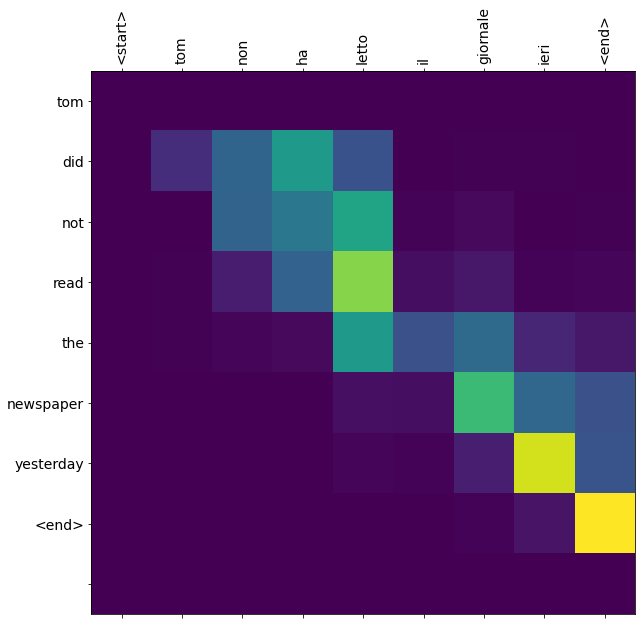

In [ ]:
num = test.sample(1).index[0]
Ita = test['italian'][num]
Eng = test['english_inp'][num]

pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[15]]
at time step 1 the word is  [[28]]
at time step 2 the word is  [[121]]
at time step 3 the word is  [[390]]
at time step 4 the word is  [[155]]
at time step 5 the word is  [[16]]
at time step 6 the word is  [[7]]
at time step 7 the word is  [[8]]
at time step 8 the word is  [[2]]

Italian:  <start> può sembrare facile però non lo è <end>
Eng_ref:  <start> it may look easy but it is not <end>
Predicted:  that can look easy but he is not <end> 

BLEU score: 4.372204660033707e-78



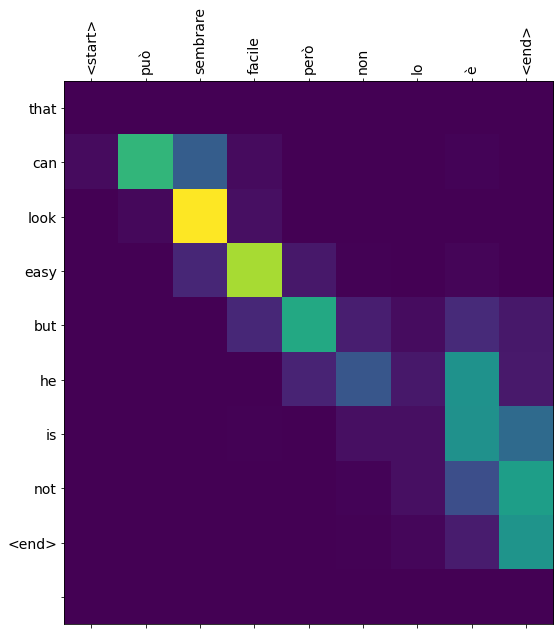

In [ ]:
num = test.sample(1).index[0]
Ita = test['italian'][num]
Eng = test['english_inp'][num]

pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[44]]
at time step 1 the word is  [[136]]
at time step 2 the word is  [[5]]
at time step 3 the word is  [[113]]
at time step 4 the word is  [[5]]
at time step 5 the word is  [[28]]
at time step 6 the word is  [[11]]
at time step 7 the word is  [[15]]
at time step 8 the word is  [[2]]

Italian:  <start> mi dicono che tom riesce a farlo <end>
Eng_ref:  <start> they tell me that tom can do that <end>
Predicted:  they say tom if tom can do that <end> 

BLEU score: 0.2846946938149361



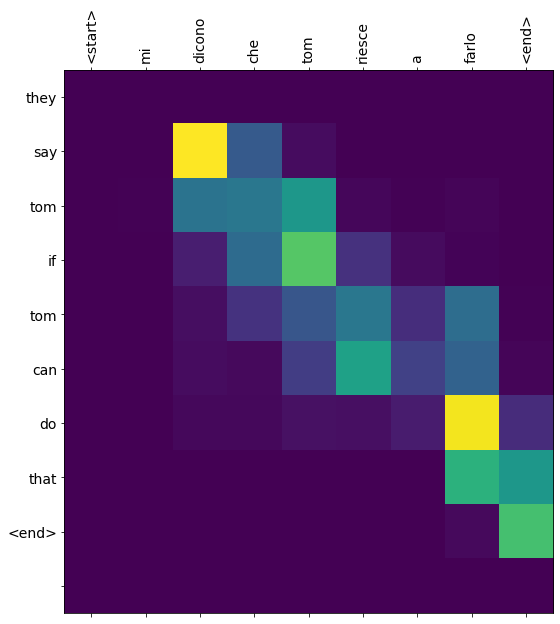

In [ ]:
num = test.sample(1).index[0]
Ita = test['italian'][num]
Eng = test['english_inp'][num]

pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[26]]
at time step 1 the word is  [[7]]
at time step 2 the word is  [[29]]
at time step 3 the word is  [[301]]
at time step 4 the word is  [[2631]]
at time step 5 the word is  [[426]]
at time step 6 the word is  [[2]]

Italian:  <start> qual è il tuo parco nazionale preferito <end>
Eng_ref:  <start> what is your favorite national park <end>
Predicted:  what is your favorite national park <end> 

BLEU score: 0.7165313105737893



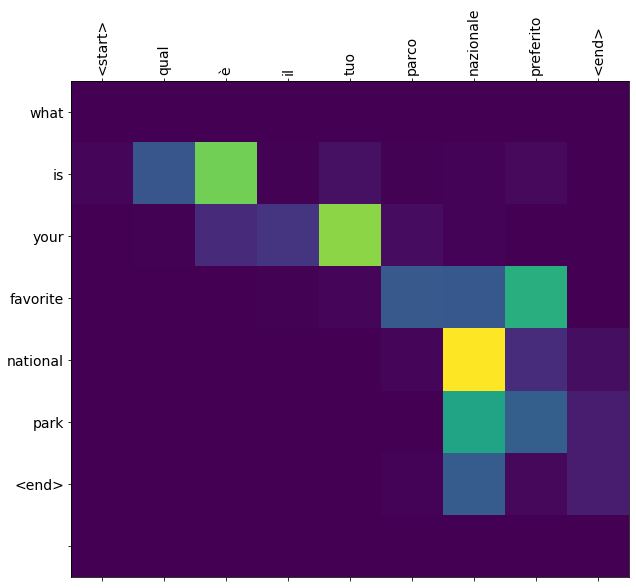

In [ ]:
num = test.sample(1).index[0]
Ita = test['italian'][num]
Eng = test['english_inp'][num]

pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
test2 = test.copy()

In [ ]:
# Calculating average bleu score on 100 val data.
REF = []
PRED = []
BLEU = []
for i in test.index[:100]:

  Ita = test['italian'][i]
  Eng = test['english_inp'][i]

  result = tknizer_ita.texts_to_sequences([Ita])
  result = pad_sequences([result[0]], maxlen=20, dtype='int32', padding='post')
  result = tf.convert_to_tensor(result)

  initial_state = model.layers[0].initialize_states(1)
  enc_output, enc_state_h, enc_state_c = model.layers[0](result, initial_state)
  state_h, state_c = enc_state_h, enc_state_c

  pred = []
  cur_vec = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)

  for j in range(20):
      infe_output, state_h, state_c, att_weights, _ = model.layers[1].onestepdecoder(cur_vec, enc_output, state_h, state_c)

      att_weights = tf.reshape(att_weights, (-1, ))
      cur_vec1 = np.argmax(infe_output)
      cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
      pred.append(cur_vec1)

      if cur_vec1 == tknizer_eng.word_index['<end>']:
        break

  result = ''
  for p in pred:

    if p != 0:
      result += tknizer_eng.index_word[p] + ' '
    
  reference = [Eng.split()[1:-1]]
  translation = result.split()[:-1]
  
  b = sentence_bleu(reference, translation)
  REF.append(Eng)
  PRED.append(result)
  BLEU.append(round(b, 4))

In [ ]:
OUTPUT = pd.DataFrame(list(zip(REF, PRED, BLEU)), columns = ['Reference', 'Predicited', 'BLEU_Score'])
OUTPUT.sample(5)

,Reference,Predicited,BLEU_Score
71,<start> your o is look like a is <end>,these or sound like <end>,0.0
48,<start> please leave the room <end>,please leave the room <end>,1.0
92,<start> which one do you prefer <end>,what do you prefer <end>,0.0
11,<start> are you watching it <end>,are you watching you <end>,0.0
2,<start> you have to go there today <end>,you have to go there today <end>,1.0


In [ ]:
print("Average bleu score on 100 validation data: {:.4f}".format(np.mean(BLEU)))

Average bleu score on 100 validation data: 0.7525
